
# Diseño de software para cómputo científico

----

## Unidad 4: Optimización, paralelismo, concurrencia y cómputo distribuido en alto nivel.


## Los imports

In [26]:
%matplotlib inline
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from bokeh.plotting import output_notebook
output_notebook()

from libs.dask_data_creation import generate_presentation_data
generate_presentation_data()

Loading BokehJS ...

Removing old data
Generating dask dataframe data sample...
Removing old data
Generating dask bag data sample...


## Dask

![image.png](imgs/collections-schedulers.png)

- Es una libreria para computacion paralela en Python.
- Esta compuesta por dos grandes partes:

    1. Por un lado tenemos la interfaz del usuario. Se usa para definir un grafo de tareas a ser ejecutadas. 
    2. Schedulers: son los encargados de ejecutar muchas funciones python en forma paralela


## Dask

#### Por qué?

* API conocida
* Se puede usar local como en cluster
* Se integra con el ecosistema Python
* Soporta aplicaciones complejas
* Tiene herramientas de diagnostico bastante útiles.
* Installen con:

```bash
$ pip install dask[complete] graphviz bokeh
```


## Dask Array

<div style="float: left; margin: 30px;"><img src="imgs/dask-array-black-text.svg" width="600" align="middle"></div>


## Dask Array

In [3]:
import dask.array as da

In [15]:
x = da.arange(25, chunks=5) # 
x

dask.array<arange, shape=(25,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

In [21]:
y = x ** 2
y

dask.array<pow, shape=(25,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

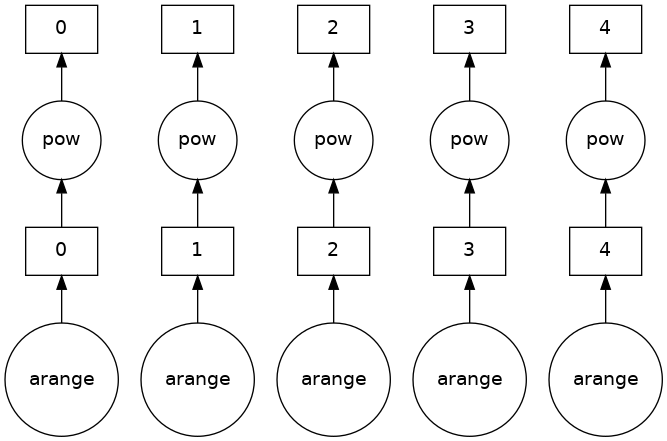

In [22]:
y.visualize()

In [23]:
%%time
y.compute()

CPU times: user 4.06 ms, sys: 10 µs, total: 4.07 ms
Wall time: 5.95 ms


array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

In [24]:
%%time
y.compute(scheduler='processes')

CPU times: user 16.4 ms, sys: 16 ms, total: 32.4 ms
Wall time: 695 ms


array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576])

### Numpy vs Dask


In [28]:
%%time
np_data = np.random.normal(1, size=(20_000, 20_000))
np_data[::50].mean(axis=0)
print("Se usaron {:.2f} GB de RAM".format(np_data.nbytes / 1024**3))

Se usaron 2.98 GB de RAM
CPU times: user 17.4 s, sys: 3.98 s, total: 21.4 s
Wall time: 21.7 s


In [ ]:
#da_data[::50].mean(axis=0).visualize() 

In [29]:
%%time
da_data = da.random.normal(1, size=(20_000, 20_000), 
                           chunks=(1_000, 1_000)) 
da_data[::50].mean(axis=0).compute()

CPU times: user 26.1 s, sys: 390 ms, total: 26.5 s
Wall time: 5.8 s


array([0.98287493, 0.99180359, 0.96981767, ..., 1.07385902, 1.0091123 ,
       1.04873778])

### Diagnostics

In [30]:
from dask.diagnostics import (Profiler, ResourceProfiler, 
                              visualize, ProgressBar)

ProgressBar().register()

In [31]:
with Profiler() as prof, ResourceProfiler(dt=0.2) as rprof:
    da_data[::50].mean(axis=0).compute()
visualize([prof, rprof], save=False);

[########################################] | 100% Completed |  6.2s


## Dask Bag


In [34]:
db.read_text?

In [46]:
import json
import dask.bag as db

data = db.read_text('db_data/*.json.gz') # NI UNO
data.take(1)

[########################################] | 100% Completed |  0.4s


('{"id": 1000, "duration": 82, "month": 1}\n',)

In [47]:
data = data.map(json.loads)
#data.visualize()
data.take(1)

[########################################] | 100% Completed |  0.4s


({'id': 1000, 'duration': 82, 'month': 1},)

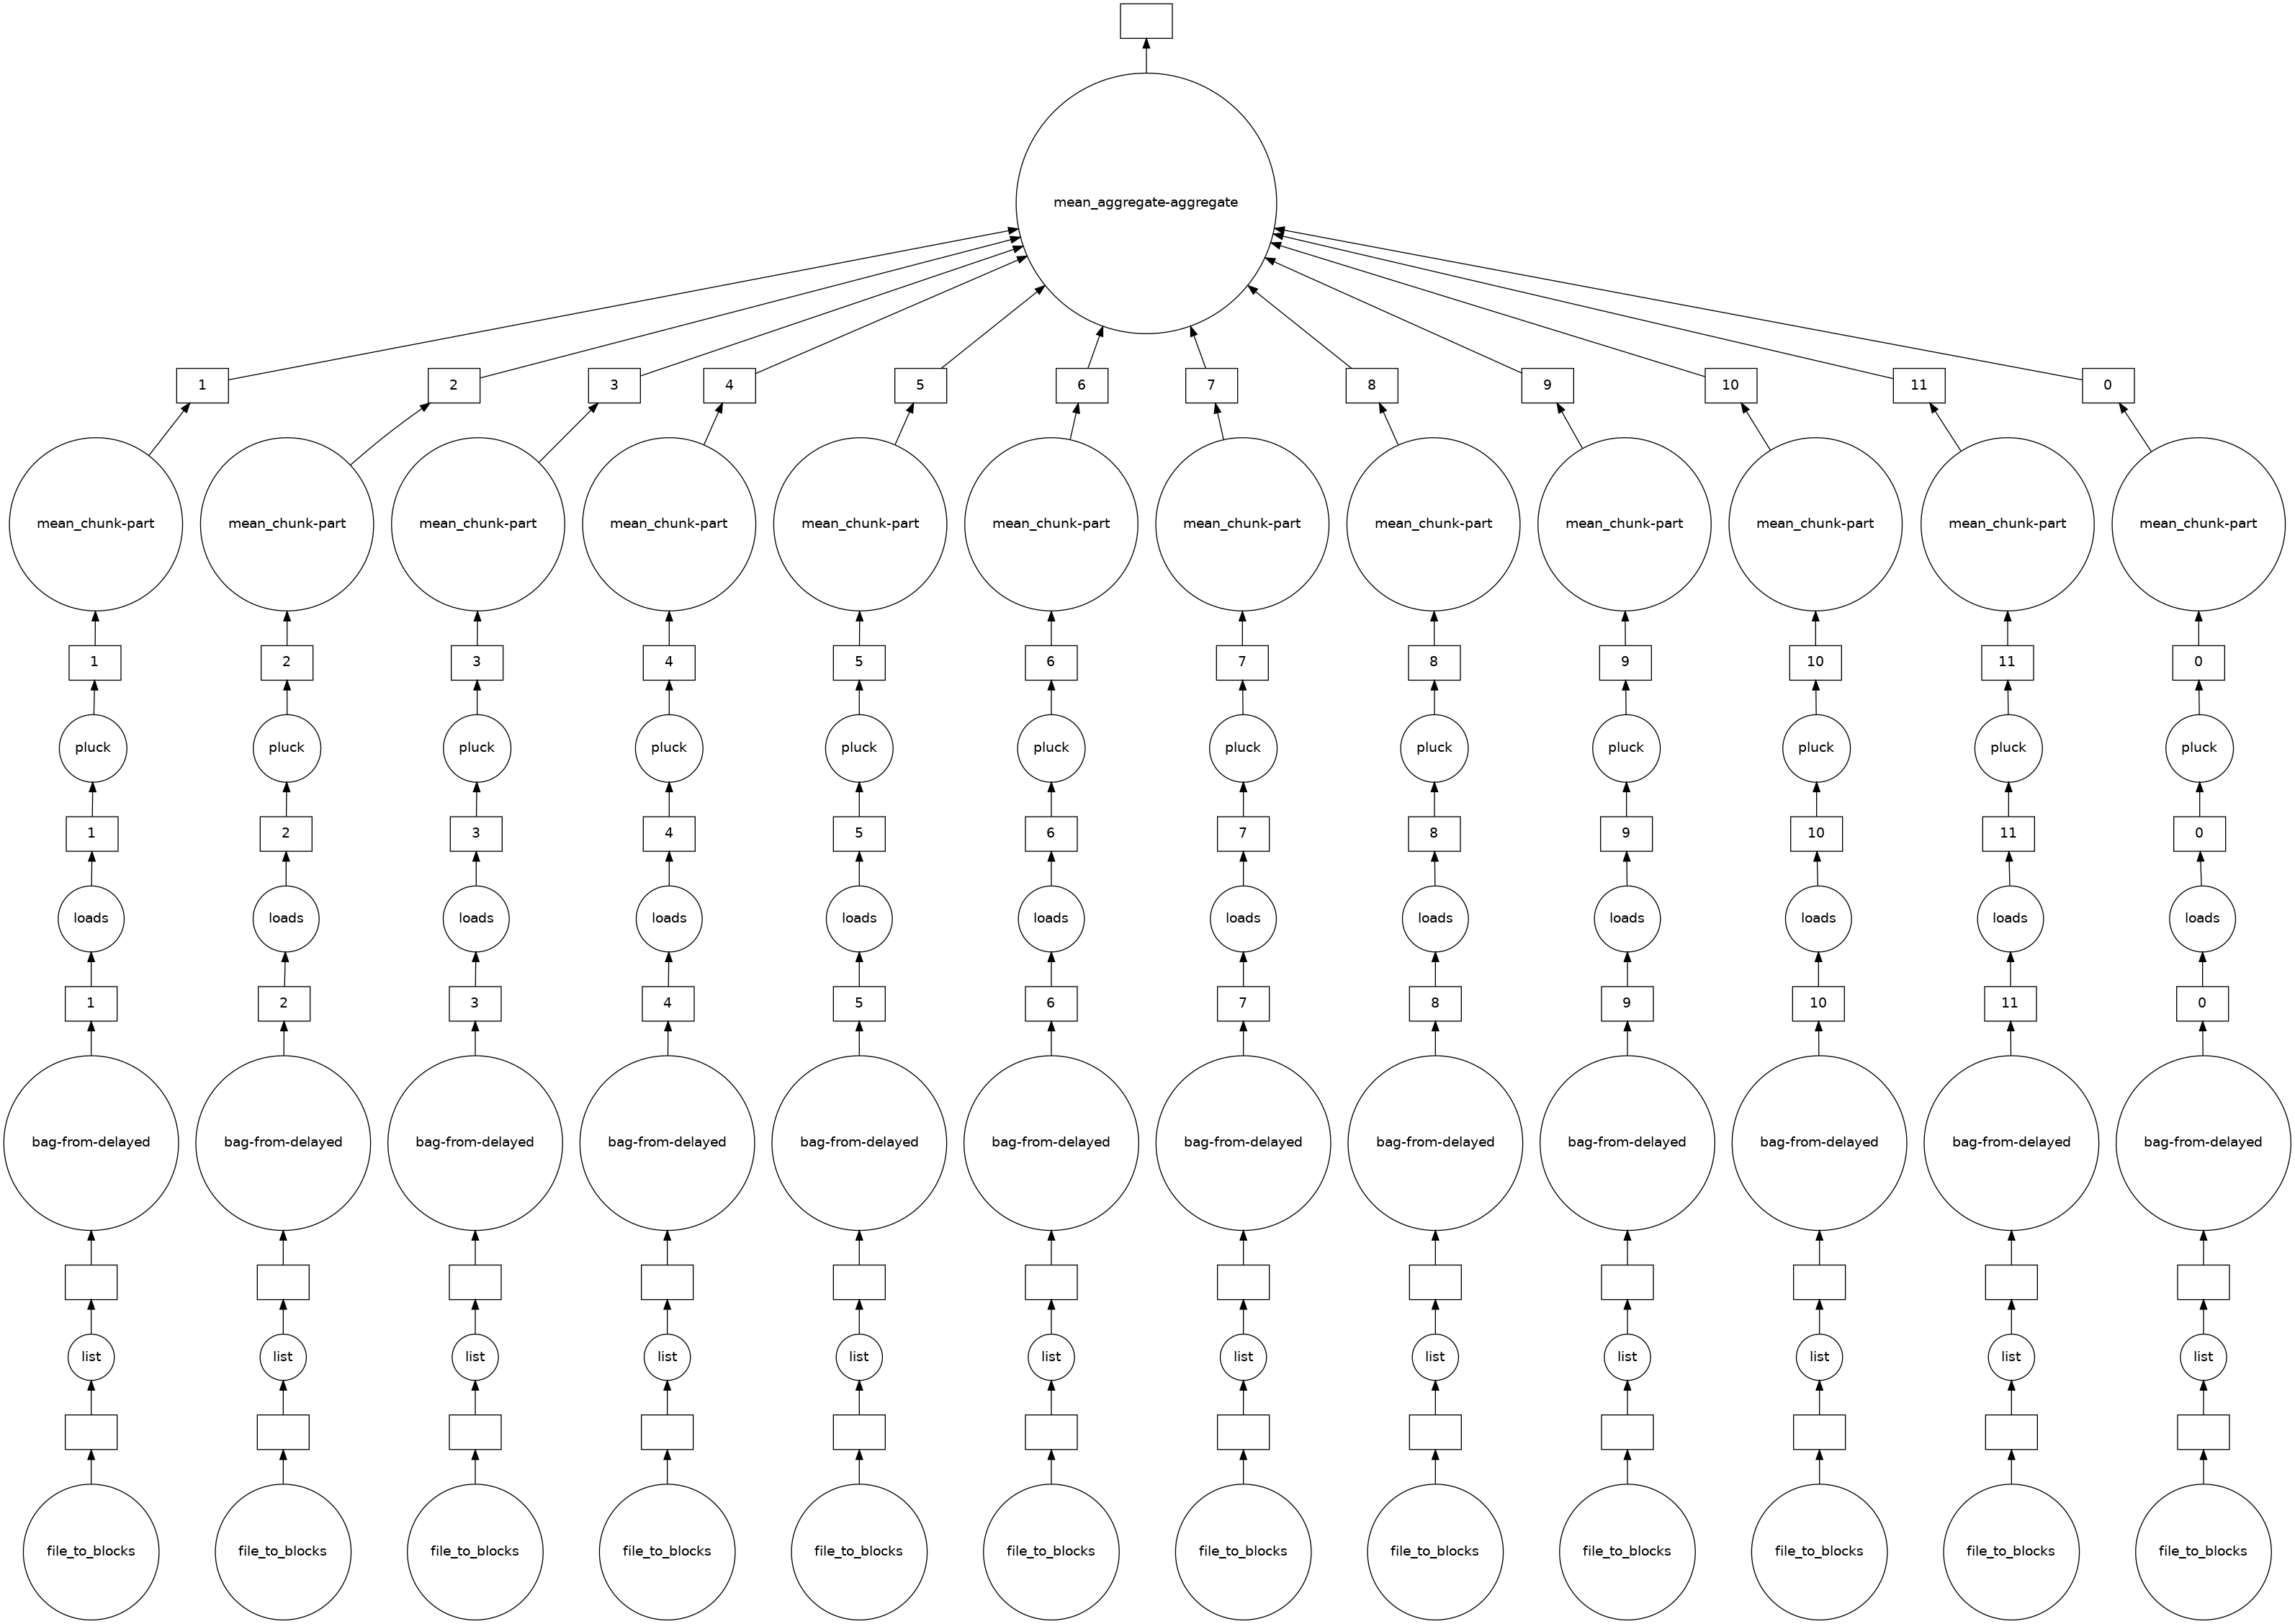

In [48]:
promedio = data.pluck('duration').mean()  
promedio.visualize()

In [49]:
promedio.compute()

[########################################] | 100% Completed |  0.4s


51.157916666666665

## Dask Dataframe

<div style="float: left; margin: 30px;"><img src="imgs/dask-dataframe.svg" width="300" align="middle"></div>


**¿Cuando usarlo?**

* El dataset no entra en memoria
* Aprovechar todos los cores para calculos complejos
* Distribuir operaciones comunes de pandas

**¿Cuando NO usarlo?**

* Los datos entran en memoria
* Los datos no son tabulares
* Se necesita hacer algún calculo no estandar

In [50]:
import dask.dataframe as dd

df = dd.read_csv('dd_data/*.csv.gz', compression='gzip', blocksize=None)
df

,id,duration,month
npartitions=12,,,
,int64,int64,int64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [51]:
%%time
promedios = df.groupby('month').duration.mean()
promedios.compute()

[########################################] | 100% Completed |  0.2s
CPU times: user 122 ms, sys: 20.5 ms, total: 143 ms
Wall time: 218 ms


month
1     51.174
10    51.471
11    51.000
12    50.172
2     51.156
3     52.182
4     51.734
5     48.779
6     52.448
7     51.256
8     51.930
9     50.593
Name: duration, dtype: float64

In [52]:
%%time
df_pandas = df.compute()
df_pandas.groupby('month').duration.mean()

[########################################] | 100% Completed |  0.1s
CPU times: user 62.2 ms, sys: 0 ns, total: 62.2 ms
Wall time: 110 ms


month
1     51.174
2     51.156
3     52.182
4     51.734
5     48.779
6     52.448
7     51.256
8     51.930
9     50.593
10    51.471
11    51.000
12    50.172
Name: duration, dtype: float64

## Delayed

Permite la creación de grafos modificando """levemente""" el código Python original

In [53]:
def inc(x):
    return x + 1

def double(x):
    return x * 2

def add(x, y):
    return x + y

output = []
for x in range(1, 6):
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)
total

50

In [55]:
from dask import delayed

@delayed
def inc(x):
    return x + 1

output = []
for x in range(1, 6):
    a = inc(x)
    b = delayed(double)(x)
    c = delayed(add)(a, b)
    output.append(c)

total = delayed(sum)(output)
total.compute()

[########################################] | 100% Completed |  0.1s


50

In [ ]:
a = {(0, 0): 1}

In [56]:
from dask.diagnostics import Profiler

with Profiler() as prof:
    print(total.compute()) 
visualize([prof], save=False);

[########################################] | 100% Completed |  0.1s
50


## "Distributed"

In [57]:
from distributed import Client

client = Client('127.0.0.1:8786')

In [64]:
promedio = data.pluck('duration').mean()
result = client.compute(promedio)
result.result()

51.157916666666665

In [63]:
result.release()

## Referencias

- Charla original: https://github.com/arielrossanigo/procesando_datos_en_paralelo_con_dask de **Ariel Rossanigo**
- Video de la charla original: https://www.youtube.com/watch?v=APcUJOVrFlk

